# <font color = lightcoral>Understand current parsing and windowing logic and device new one
>    
### <font color = red>Interleaved Sliding Window - Non Overlapping
> this is the case where every 10th period is part of the test set, whereas data from periods 1-8 are part of the train set

## <font color = grey> Admin

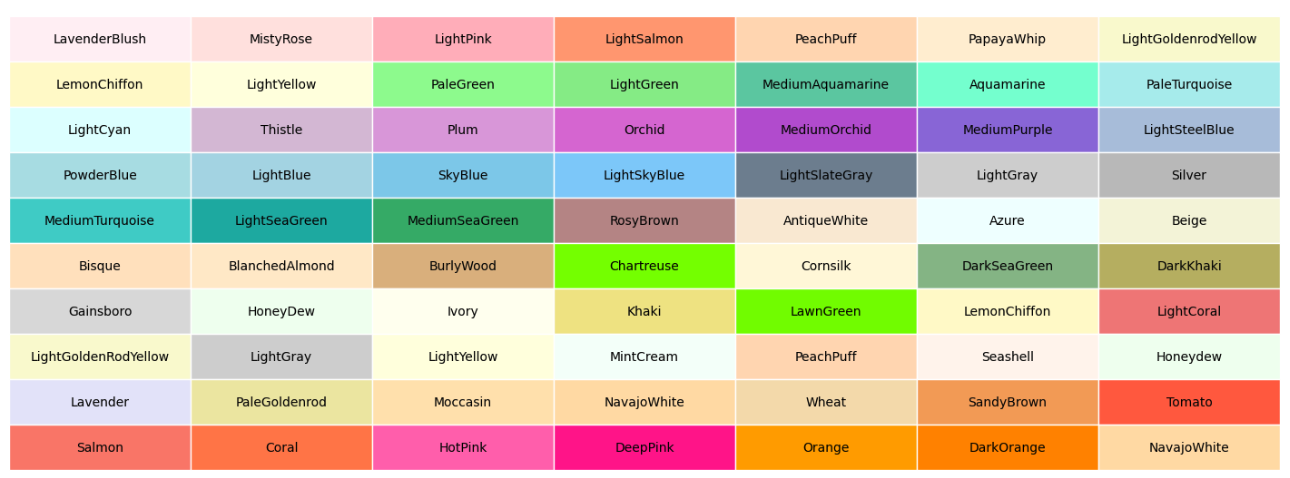

In [1]:
import pandas as pd
import os
import gzip
import time
import warnings
import os
import shutil
from datetime import datetime
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

Base directory set to: /home/sagemaker-user


___
# <font color = darkkhaki> Data Prep --> Create sample for sanity testing

In [12]:
import pandas as pd

# Define the input and output file paths
input_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base'
input_file = f"{input_dir}/20240704__full__new_features_v1.10.parquet"

output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base'
output_file = f"{output_dir}/20240704__sample__new_features_v1.50.parquet"

# Read the parquet file
df = pd.read_parquet(input_file)

# Select the first 100 rows
first_100k_rows = df.head(1000)

# Save the selected data to a new parquet file
first_100k_rows.to_parquet(output_file, index=False)

print(f"The first 1000 rows have been saved to {output_file}")

The first 1000 rows have been saved to /home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base/20240704__sample__new_features_v1.50.parquet


In [13]:
import pandas as pd

####################### Full Base ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base/'
# input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"

####################### Sample Base ######################################
data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base/'
input_file = f"{data_dir}/20240704__sample__new_features_v1.50.parquet"

####################### Full Test_Train ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/02.Full_Train_Test/'
# input_file = f"{data_dir}/20240704__train__new_features_v1.10.parquet"
# input_file = f"{data_dir}/20240704__test__new_features_v1.10.parquet"

####################### Sample Test_Train ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/04.Sample_Train_Test/'
# input_file = f"{data_dir}/20240705_train_claude.parquet"
# input_file = f"{data_dir}/20240705_test_claude.parquet"
# input_file = f"{data_dir}/X_train.parquet"

# Read the parquet file
df = pd.read_parquet(input_file)

# Count the number of rows
row_count = len(df)

print("*"*100 + "\n")
print("************************************** # Rows ********************************")

print(f"The number of rows in the parquet file is: {row_count}")

# print("*"*100 + "\n")
print("************************************** Distinct Records by Class ****************")

# Count the number of distinct records by Class
distinct_class_counts = df['Class'].value_counts()

print(f"The count of distinct records by Class is:\n{distinct_class_counts}")

print("************************************** Shape ***************************")

print(df.shape)

print("************************************** Columns *************************")

print(df.columns)

# print("*"*100 + "\n")
print("************************************** Display Sample ********************************")

# Select the first 8 columns (assuming they exist)
first_eight_columns = df.iloc[:, :12]  # Use indexing for columns

# Display the first few rows of the selected columns
display(first_eight_columns.head(5))

****************************************************************************************************

************************************** # Rows ********************************
The number of rows in the parquet file is: 1000
************************************** Distinct Records by Class ****************
The count of distinct records by Class is:
Class
0    862
1    138
Name: count, dtype: int64
************************************** Shape ***************************
(1000, 35440)
************************************** Columns *************************
Index(['time_start', 'time_start_int', 'Class', 'unique_events',
       'most_frequent_event', 'transitions', 'entropy', 'EventId_1',
       'EventId_2', 'EventId_3',
       ...
       'EventId_35424', 'EventId_35425', 'EventId_35426', 'EventId_35427',
       'EventId_35428', 'EventId_35429', 'EventId_35430', 'EventId_35431',
       'EventId_35432', 'EventId_35433'],
      dtype='object', length=35440)
******************************

,time_start,time_start_int,Class,unique_events,most_frequent_event,transitions,entropy,EventId_1,EventId_2,EventId_3,EventId_4,EventId_5
0,2005-06-03 15:40:00,0,0,1,228,0,0.000000,228,228,228,228,228
1,2005-06-03 15:45:00,1,0,2,228,2,0.005288,228,228,228,228,228
2,2005-06-03 15:50:00,2,0,3,228,14,0.073091,228,228,228,228,228
3,2005-06-03 15:55:00,3,0,1,228,0,0.000000,228,228,228,228,228
4,2005-06-03 16:00:00,4,0,6,228,6,0.171708,228,228,228,228,228


----

___
# <font color = darkkhaki> Feature Engg - Chat GPT

### <font color = grey> Reduce the Number of Columns

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

####################### Full Base ######################################
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base/'
# input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"
# output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/02.Full_Train_Test'

####################### Sample Base ######################################
data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base/'
input_file = f"{data_dir}/20240704__sample__new_features_v1.50.parquet"
output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/04.Sample_Train_Test'

# Load the data
df = pd.read_parquet(input_file)

# Select derived features and a subset of EventID columns
selected_columns = ['time_start_int', 'Class', 'unique_events', 'most_frequent_event', 'transitions', 'entropy']
# event_id_columns = [f'EventId_{i}' for i in range(1, 35397)]  # All EventID columns
event_id_columns = [col for col in df.columns if col.startswith('EventId_')]

# Replace -1 values with 0
df[event_id_columns].replace(-1, 0, inplace=True)

### <font color = grey>Scaling and Encode

In [15]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['unique_events', 'transitions', 'entropy']
df[selected_columns[2:]] = scaler.fit_transform(df[selected_columns[2:]])

# Encode categorical features
label_encoder = LabelEncoder()
df['most_frequent_event'] = label_encoder.fit_transform(df['most_frequent_event'])

### <font color = grey>PCA

In [16]:
# Apply PCA to EventID columns to reduce them to 50 features
pca = PCA(n_components=50)
event_id_pca = pca.fit_transform(df[event_id_columns])

# Create a new DataFrame with the reduced EventID features
event_id_pca_df = pd.DataFrame(event_id_pca, columns=[f'EventId_PCA_{i+1}' for i in range(50)])

# Combine the reduced EventID features with the selected columns
df_reduced = pd.concat([df[selected_columns], event_id_pca_df], axis=1)

### <font color = grey>Create Sequences for Time Series Model

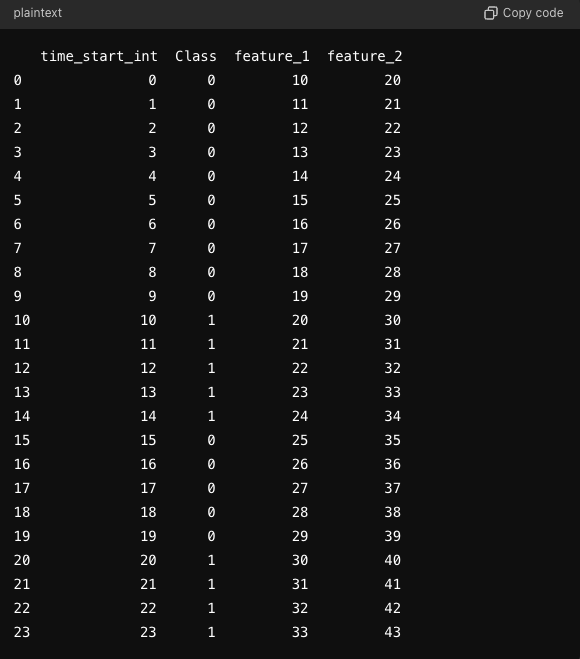

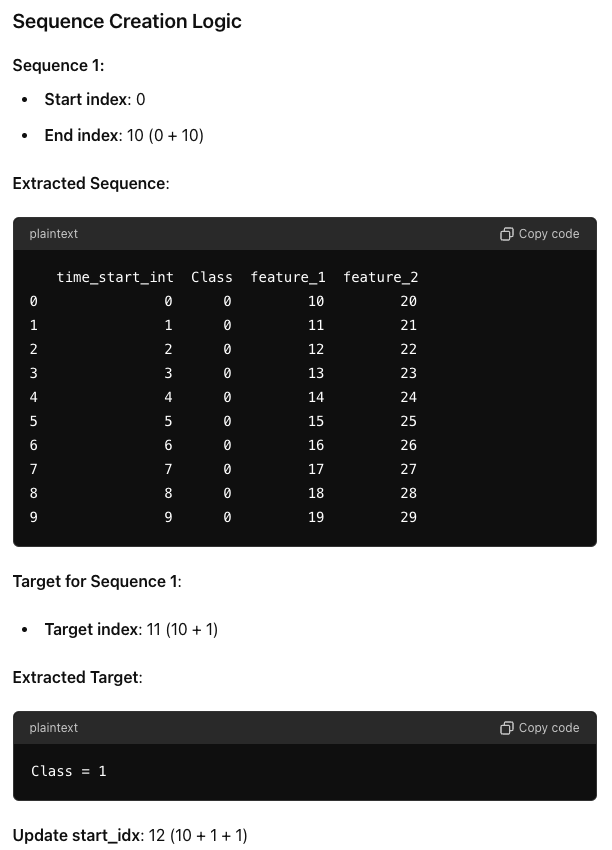

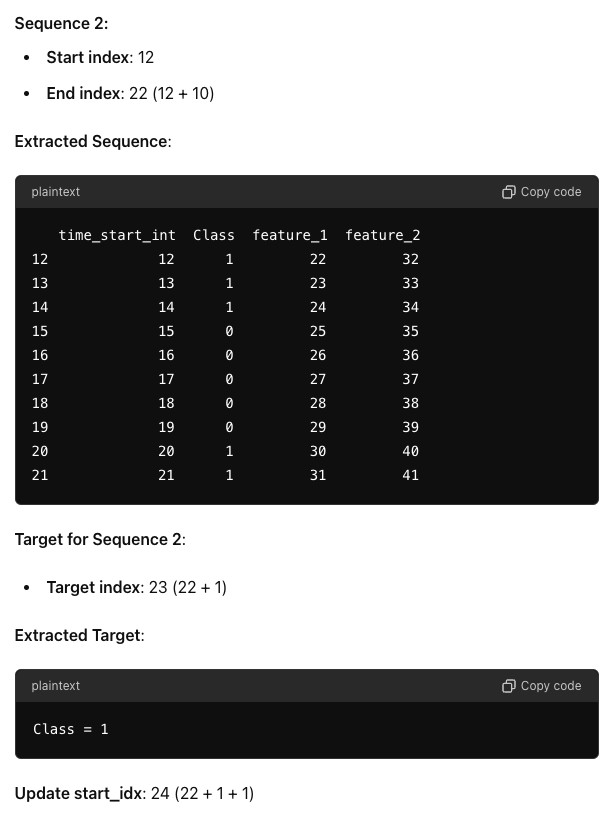

In [17]:
# Function to create non-overlapping sequences
def create_sequences(data, time_index_col, feature_cols, target_col, input_length=10, gap=1, prediction_period=1):
    sequences = []
    targets = []
    
    start_idx = 0
    while start_idx + input_length + gap + prediction_period <= len(data):
        end_idx = start_idx + input_length
        sequence = data[feature_cols].iloc[start_idx:end_idx].values
        target = data[target_col].iloc[end_idx + gap:end_idx + gap + prediction_period].values[0]
        sequences.append(sequence)
        targets.append(target)
        start_idx = end_idx + gap + prediction_period  # Move to the next non-overlapping sequence
    
    return np.array(sequences), np.array(targets)

# feature_cols = selected_columns + selected_event_ids
feature_cols = [col for col in df_reduced.columns if col != 'Class']
target_col = 'Class'

X, y = create_sequences(df_reduced, 'time_start_int', feature_cols, target_col)

### <font color = grey>Split Data into Training and Testing Sets

In [18]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### <font color = grey>Drop time_start_int

In [19]:
# Drop the first column from X_train and X_test
X_train = X_train[:, :, 1:]
X_test = X_test[:, :, 1:]

In [20]:
np.save(f'{output_dir}/X_train.npy', X_train)
np.save(f'{output_dir}/X_test.npy', X_test)
np.save(f'{output_dir}/y_train.npy', y_train)
np.save(f'{output_dir}/y_test.npy', y_test)

### <font color = grey>Dataset Shape

In [22]:
import numpy as np

data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/03.Sample_Base/'
input_file = f"{data_dir}/20240704__sample__new_features_v1.30.parquet"
output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/04.Sample_Train_Test'

####### Load inline #########

# print("Shape of X_train[:1]:", X_train[:1].shape)
# print("Shape of y_train[:1]:", y_train[:1].shape)

# print("Shape of X_test[:1]:", X_test[:1].shape)
# print("Shape of y_test[:1]:", y_test[:1].shape)

########## Load Saved ############
# Load the saved data using np.load
X_train = np.load(f'{output_dir}/X_train.npy')
X_test = np.load(f'{output_dir}/X_test.npy')
y_train = np.load(f'{output_dir}/y_train.npy')
y_test = np.load(f'{output_dir}/y_test.npy')

print("************************************** Data Shape *****************************")

# Print the shapes of the loaded data
print("Shape of X_train[:]:", X_train[:1].shape)
print("Shape of y_train[:]:", y_train[:1].shape)

print("Shape of X_test[:]:", X_test[:1].shape)
print("Shape of y_test[:]:", y_test[:1].shape)

print("************************************** Count of Sequences *****************************")

# Number of sequences in X_train and X_test
num_train_sequences = X_train.shape[0]
num_test_sequences = X_test.shape[0]

print("Number of sequences in X_train:", num_train_sequences)
print("Number of sequences in X_test:", num_test_sequences)

# Number of rows in y_train and y_test
num_y_train_rows = y_train.shape[0]
num_y_test_rows = y_test.shape[0]

print("Number of rows in y_train:", num_y_train_rows)
print("Number of rows in y_test:", num_y_test_rows)

************************************** Data Shape *****************************
Shape of X_train[:]: (1, 10, 54)
Shape of y_train[:]: (1,)
Shape of X_test[:]: (1, 10, 54)
Shape of y_test[:]: (1,)
************************************** Count of Sequences *****************************
Number of sequences in X_train: 66
Number of sequences in X_test: 17
Number of rows in y_train: 66
Number of rows in y_test: 17


### <font color = tomato> Derived Features

* unique_events: The number of unique events in the 5-minute interval.

* most_frequent_event: The most frequent event in the interval.

* transitions: The number of transitions between different events.

* entropy: The entropy of the events.

* Class: The target label, which was included in the sequence but will be excluded from features for model training.

In [23]:
# Display the entire content of X_train[:1]
np.set_printoptions(threshold=np.inf)  # Ensure full array print
print("X_train[:1]:\n", X_train[2:3])

X_train[:1]:
 [[[-1.61809486e-03  7.00000000e+00 -1.24468520e-01  1.07929626e+00
   -7.61951507e+03  6.54700701e+02 -7.33643390e+02 -1.30725880e+03
    9.08767073e+01 -1.04597967e+02  3.25201393e+02 -2.29242624e+02
   -8.09012102e+01  2.76774719e+02  6.10545493e+01 -6.01816913e+01
    1.74486076e+01  1.04468409e+01 -1.02320670e+01  1.16632218e+01
    7.06334769e+00 -5.37184877e+01 -1.84391747e+02  1.69170330e+02
    1.14073422e+02 -1.46421687e+02  2.84634882e+01 -3.11571919e+01
   -5.44912644e+01  5.12143590e+01 -1.11493119e+01 -9.35392592e+00
   -2.61144855e+01 -8.76750158e+01  1.99135951e+01  1.70945022e+01
   -1.02716495e+01 -9.66256132e+00  4.59960416e+00  1.70222932e+01
   -7.55989575e+01  5.05036235e+01 -2.32729554e+01 -4.97691540e+00
   -3.53415069e+01  1.79457065e+01  1.07838559e+01  2.25989778e+01
    1.35735858e+00  5.52063661e+00  1.77105425e+01 -9.47056526e-01
   -8.95495181e+00  9.70999346e+00]
  [ 5.37746860e-01  7.00000000e+00 -1.22617559e-01  2.14909796e+00
   -7.580224

In [24]:
# Display the entire content of X_train[:1]
np.set_printoptions(threshold=np.inf)  # Ensure full array print
print("y_train[:1]:\n", y_train[:])

y_train[:1]:
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
# Display the entire content of X_train[:1]
np.set_printoptions(threshold=np.inf)  # Ensure full array print
print("X_test[:1]:\n", X_test[:1])

X_test[:1]:
 [[[-3.61194731e-01  1.30000000e+01 -1.25702494e-01 -6.16299307e-01
   -7.62545996e+03  6.58241562e+02 -7.35592037e+02 -1.31950788e+03
    9.15267806e+01 -1.05071148e+02  3.35502279e+02 -2.39249567e+02
   -8.18877499e+01  2.91360452e+02  6.84951572e+01 -6.37018029e+01
    1.43148175e+01  1.64148603e+01 -5.15556331e+00  1.88390896e+01
    1.10826830e+01 -6.24308785e+01 -2.08172321e+02  2.00237038e+02
    1.30846485e+02 -1.61032971e+02  3.02014537e+01 -3.03062306e+01
   -6.15091758e+01  5.05001253e+01 -2.29935557e+01 -1.42388064e+01
   -2.48295355e+01 -1.05079994e+02  2.15362034e+01  1.95751102e+01
   -9.78374588e+00 -6.00846408e+00  6.06299381e+00  1.82591229e+01
   -1.12387435e+02  9.52345064e+01 -4.54435190e+01 -6.84411940e+00
   -7.07661735e+01  3.27772301e+01  1.51070769e+01  4.42290599e+01
    6.64600703e+00  7.69596389e+00  3.28275812e+01 -2.59387541e+00
   -9.36784618e+00 -1.84686192e+00]
  [-3.61194731e-01  1.30000000e+01 -1.25702494e-01 -6.16299307e-01
   -7.6180662

In [26]:
# Display the entire content of X_train[:1]
np.set_printoptions(threshold=np.inf)  # Ensure full array print
print("y_test[:1]:\n", y_test[:])

y_test[:1]:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


___
# <font color = darkkhaki> LSTM - ChatGPT

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 54  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 50
batch_size = 16
learning_rate = 0.001

In [28]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.6206
Epoch [2/50], Loss: 0.5518
Epoch [3/50], Loss: 0.3764
Epoch [4/50], Loss: 0.4328
Epoch [5/50], Loss: 0.1294
Epoch [6/50], Loss: 0.0968
Epoch [7/50], Loss: 0.4696
Epoch [8/50], Loss: 0.1166
Epoch [9/50], Loss: 0.1924
Epoch [10/50], Loss: 0.1743
Epoch [11/50], Loss: 0.1564
Epoch [12/50], Loss: 0.0902
Epoch [13/50], Loss: 1.1909
Epoch [14/50], Loss: 0.1296
Epoch [15/50], Loss: 0.1627
Epoch [16/50], Loss: 0.1318
Epoch [17/50], Loss: 0.1169
Epoch [18/50], Loss: 0.0771
Epoch [19/50], Loss: 0.0867
Epoch [20/50], Loss: 0.0845
Epoch [21/50], Loss: 0.0753
Epoch [22/50], Loss: 0.0894
Epoch [23/50], Loss: 0.0797
Epoch [24/50], Loss: 0.0594
Epoch [25/50], Loss: 0.1420
Epoch [26/50], Loss: 0.0648
Epoch [27/50], Loss: 0.5698
Epoch [28/50], Loss: 0.0770
Epoch [29/50], Loss: 0.0396
Epoch [30/50], Loss: 0.0890
Epoch [31/50], Loss: 0.0342
Epoch [32/50], Loss: 0.0925
Epoch [33/50], Loss: 0.0270
Epoch [34/50], Loss: 0.0100
Epoch [35/50], Loss: 0.0130
Epoch [36/50], Loss: 0.0973
E

Confusion Matrix:
 [[17]]
Precision: 0.0000
Recall: 0.0000
Accuracy: 1.0000
F1 Score: 0.0000


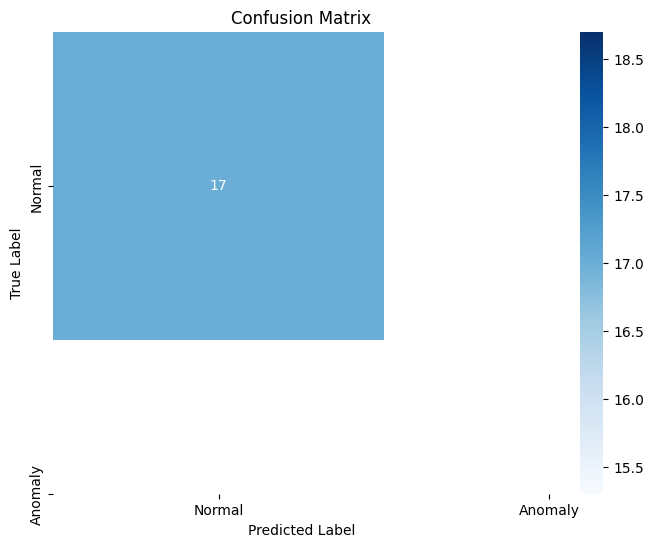

In [30]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outputs = torch.sigmoid(test_outputs)  # Apply sigmoid to get probabilities
    test_outputs = test_outputs.cpu().numpy()
    y_test_tensor = y_test_tensor.cpu().numpy()
    test_preds = (test_outputs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test_tensor, test_preds)
precision = precision_score(y_test_tensor, test_preds)
recall = recall_score(y_test_tensor, test_preds)
accuracy = accuracy_score(y_test_tensor, test_preds)
f1 = f1_score(y_test_tensor, test_preds)

print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()